In [1]:
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import words as nltk_words
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import emoji
import swifter

#model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize


#visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


#nltk dependency
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('words')

[nltk_data] Downloading package stopwords to /home/wawan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/wawan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/wawan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package words to /home/wawan/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
# loading dataset
# file_name = "blibli_app_review.csv"

data = pd.read_csv('output/blibli_app_review.csv')
data['content'].sample(10, random_state=None)

20851                             Ini kok gak bisa cod sih
11452    2dulu lah..baru klik pay langsung tolak.. Ment...
34001                                             Blibi ok
5456                                          Sangat bagus
3102     Barang nya murah murah tapi gak bisa cod 😑sama...
7392                          smoga blibli smakin terdepan
10625                                               Koplak
34888    Tolong libih di tingkatkan playananya. Smoga m...
33773                                            No coment
14112    Aplikasinya mantep. Belanja online jadi makin ...
Name: content, dtype: object

In [3]:
#selecting awal

#jika da panjang 'content' hanya senilai 4 atau null, maka drop
data_filtered = data[data['content'].str.split().str.len() >= 4].copy()
data_filtered = data_filtered[data_filtered['content'].str.strip() != '']

#ganti nama score -> rating
data_filtered = data_filtered.rename(columns={'score': 'rating'})

print("Jumlah data orisinil", data.shape)
print("Setelah filter:", data_filtered.shape)
data_filtered.head()

df = data_filtered.copy()

Jumlah data orisinil (40820, 8)
Setelah filter: (28699, 8)


## Rekayasa Fitur

In [4]:
#membuat labeling kelas
def label_sentimen(rating):
    if rating >= 4:
        return 'positif'
    elif rating <= 2:
        return 'negatif'
    else:
        return 'netral'

df['label'] = df['rating'].apply(label_sentimen)
dataframe = df

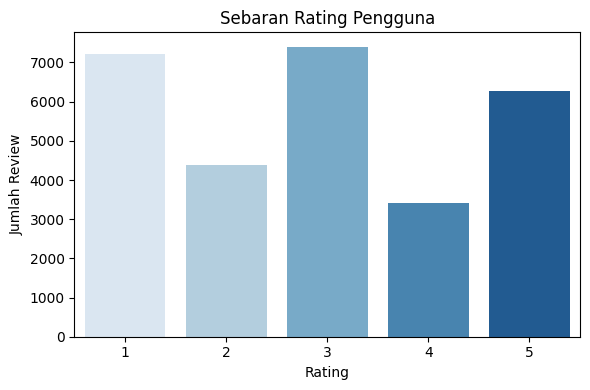

In [5]:
#visualisasi Sebaran Rating

plt.figure(figsize=(6, 4))
sns.countplot(data=dataframe, x='rating', palette='Blues')
plt.title('Sebaran Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()


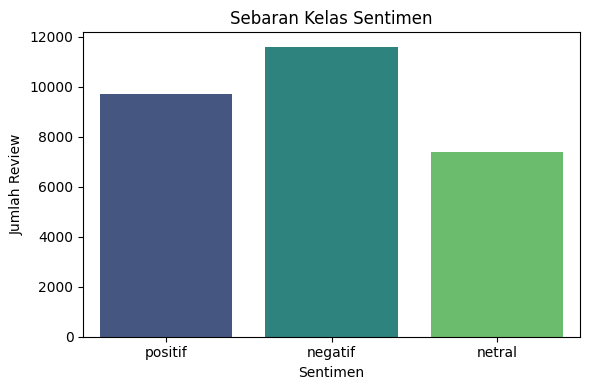

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=dataframe, x='label', palette='viridis')
plt.title('Sebaran Kelas Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

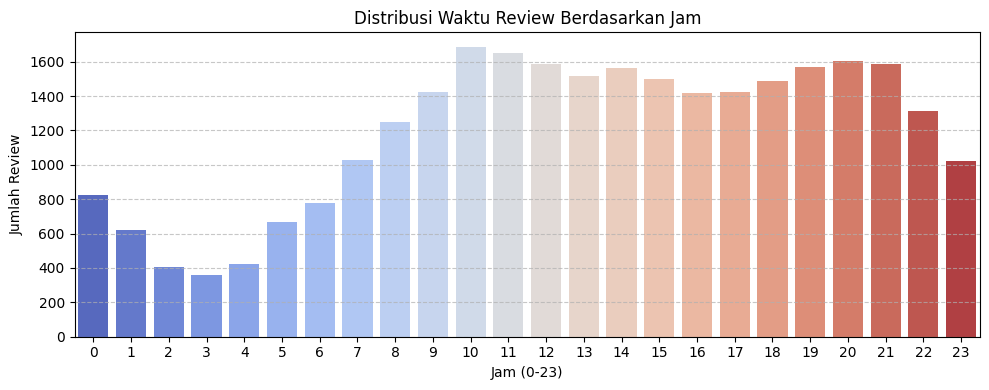

In [7]:
# Distribusi Review pengguna berdasarkan jam
dataframe['created_at'] = pd.to_datetime(dataframe['created_at'], errors='coerce')

df['hour'] = df['created_at'].dt.hour

plt.figure(figsize=(10, 4))
sns.countplot(data=dataframe, x='hour', palette='coolwarm')
plt.title('Distribusi Waktu Review Berdasarkan Jam')
plt.xlabel('Jam (0-23)')
plt.ylabel('Jumlah Review')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Text Preprocessing

In [8]:
positive_df = dataframe[dataframe['label'] == 'positif'].sample(min(2000, dataframe[dataframe['label'] == 'positif'].shape[0]), random_state=42)
netral_df = dataframe[dataframe['label'] == 'netral'].sample(min(2000, dataframe[dataframe['label'] == 'netral'].shape[0]), random_state=42)
negatif_df = dataframe[dataframe['label'] == 'negatif'].sample(min(2000, dataframe[dataframe['label'] == 'negatif'].shape[0]), random_state=42)


sampled_df = pd.concat([positive_df, netral_df, negatif_df])

sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Jumlah data setelah pengambilan 6500 sampel per kelas:", sampled_df.shape)
print("\nSebaran data per kelas setelah sampling:")
print(sampled_df['label'].value_counts())

dataframe = sampled_df.copy()


Jumlah data setelah pengambilan 6500 sampel per kelas: (6000, 10)

Sebaran data per kelas setelah sampling:
label
positif    2000
netral     2000
negatif    2000
Name: count, dtype: int64


In [9]:
def clean_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()

    # Hilangkan newline
    text = re.sub(r'\n', ' ', text)

    # Hilangkan URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Hilangkan mention dan hashtag
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Hilangkan angka dan tanda baca
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

    # Hilangkan emoji
    text = emoji.replace_emoji(text, replace='')

    # Hilangkan spasi berlebihan
    text = re.sub(r'\s{2,}', ' ', text).strip()

    # Load kamus slang
    path_kamus = 'dataset/slangs.csv'
    kamus = pd.read_csv(path_kamus)
    kamus_dict = dict(zip(kamus['Slang'].astype(str).str.lower(), kamus['Baku'].astype(str).str.lower()))

    # Replacing slang
    words = text.split()
    normalized = [kamus_dict.get(word, word) for word in words]

    return ' '.join(normalized)

In [10]:
dataframe['cleaned'] = dataframe['content'].swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

In [11]:
dataframe.shape
dataframe[['content', 'cleaned']].sample(20, random_state=None)

,content,cleaned
5765,Bagus dapat Hp baru gue Nanti klo udah Terkiri...,bagus dapat handphone baru saya nanti kalau su...
4366,Kenapa transfer via ATM BRI yg ada tanda ATM b...,kenapa transfer via atm bri yang ada tanda atm...
3831,proses pembayaran mudah.. selanjutnya perlu di...,proses pembayaran mudah selanjutnya perlu dita...
5668,"Harga nya memang murah,, namun tidak sesuai ba...",harga nya memang murah namun tidak sesuai seka...
822,mantap dan bagus di banding app lainnya,mantap dan bagus di banding aplikasi lainnya
1207,Ok lah aplikasi nya,oke lah aplikasi nya
4307,semoga yang saya inginkan yaitu metode pembaya...,semoga yang saya inginkan yaitu metode pembaya...
4486,Kok sekarang pencarian minuman alkohol langsun...,kok sekarang pencarian minuman alkohol langsun...
4698,Aplikasi jelek ngak kaya dulu kalau dulu pengi...,aplikasi jelek tidak kaya dulu kalau dulu peng...
5957,Saya coba dulu nnti kalo bagus saya kasih bint...,saya coba dulu nanti kalau bagus saya kasih bi...


In [12]:
import re
import pandas as pd
from collections import Counter

def words(text):
    return re.findall(r'\w+', text.lower())

# Load dari slangs.csv
df = pd.read_csv('dataset/slangs.csv')
basic_words = df['Baku'].dropna().astype(str).str.lower().tolist()

# # Load dari kata_dasar_KBBI.txt
with open('dataset/kata_dasar_KBBI.txt', 'r', encoding='utf-8') as f:
  kbbi_lines = [line.strip().lower() for line in f if line.strip()]
  kbbi_words = []
  for line in kbbi_lines:
    kbbi_words.extend(line.split())

#kata kata bahasa inggris
ENGLISH_WORDS = set(word.lower() for word in nltk_words.words())

BRAND_WORDS = set([
    "blibli", "tokopedia", "bukalapak", "shopee", "lazada",
    "grab", "gojek", "indomaret", "alfamart", "bca", "bni", "bri",
    "mandiri", "gopay", "ovo", "dana", "linkaja", "jnt", "jne", "sicepat", "indomaret", "alfamart",
    "bank"
])

combined_words = basic_words + kbbi_words + list(ENGLISH_WORDS) + list(BRAND_WORDS)
WORD_SET = set(w for w in combined_words if w.strip() and len(w) > 1)
WORDS = Counter(w for w in combined_words if w in WORD_SET)
WORDS = Counter(combined_words)
WORD_SET = set(combined_words)


def P(word, N=sum(WORDS.values())):
    return WORDS[word] / N

def correction(word):
    return max(candidates(word), key=P)

def candidates(word):
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def correct_sentence(sentence):
    tokens = re.findall(r'\w+', sentence.lower())
    corrected = [correction(word) for word in tokens]
    return ' '.join(corrected)

def segment(word, dictionary=WORD_SET):
    """Segment word menjadi kata-kata baku valid dari dictionary"""
    n = len(word)
    dp = [None] * (n + 1)
    dp[0] = []

    for i in range(1, n + 1):
        for j in range(i):
            if dp[j] is not None and word[j:i] in dictionary:
                dp[i] = dp[j] + [word[j:i]]
                break
    return dp[-1]

def expand_numeric_repetition(word):
    match = re.match(r'([a-z]+)(\d+)', word)
    if match:
        base, count = match.groups()
        try:
            repeat = int(count)
            return ' '.join([base] * repeat)
        except:
            pass
    return word

def normalize_word(word):
    raw_word = word  # simpan kata asli
    word = re.sub(r'[^\w\s]', '', word.lower())

    # Cek langsung dari raw lowercase
    if raw_word.lower() in BRAND_WORDS:
        return raw_word.lower()

    if word in BRAND_WORDS:
        return word

    if word in ENGLISH_WORDS:
        return word

    expanded = expand_numeric_repetition(word)
    if expanded != word:
        return ' '.join(normalize_word(w) for w in expanded.split())

    if ' ' in word:
        return ' '.join(normalize_word(w) for w in word.split())

    if word in WORD_SET and len(word) > 2:
        return word

    segmented = segment(word)
    if segmented and all(len(w) > 2 for w in segmented):
        return ' '.join(correction(w) for w in segmented)

    return correction(word)

def normalize_sentence(sentence):
    tokens = re.findall(r'\w+', sentence.lower())
    return ' '.join(normalize_word(token) for token in tokens)


In [13]:
#test fungsi
kalimat = "prduk tokpedia ggal apliks bsuk"
print(normalize_word(kalimat))

produk tokopedia gagal aplikasi busuk


In [14]:
import swifter
dataframe['replaced_slangs'] = dataframe['cleaned'].swifter.apply(correct_sentence)
dataframe['norm_norvig'] = dataframe['replaced_slangs'].swifter.apply(normalize_sentence)
dataframe['normalized_text'] = dataframe['norm_norvig']  # Alias untuk konsistensi


Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

In [15]:
pd.set_option('display.max_colwidth', None)
dataframe[["cleaned","normalized_text","label"]].sample(20)

,cleaned,normalized_text,label
5511,kak saya pengguna blibli aktif dan saya upgrade android versi handphone samsung as dan saya mengalami kendala dalam buka aplikasi untuk handphone terbaruku namun saya coba di handphone asus yang android nya masih versi untuk menggunakan aplikasi blibli lancar mohon agar diperbaiki agar support untuk android versi dan keatas ya kak tanks,kak saya pengguna blibli aktif dan saya upgrade android versi handphone sambung as dan saya mengalami kendala dalam buka aplikasi untuk handphone terbuku namun saya coba di handphone arus yang android nya masih versi untuk menggunakan aplikasi blibli lancar mohon agar diperbaiki agar support untuk android versi dan kertas ya kak tank,positif
2632,pc gamesnya dikit tolong dibanyakin,pc gamesnya dikit tolong dibanyakin,netral
2353,pihak beli beli laptop saya beli baru di retur di periksa des sampai sekarang belum ada kabar di ganti baru atau solusi nya harap di urus,pihak beli beli laptop saya beli baru di retur di periksa des sampai sekarang belum ada kabar di ganti baru atau solusi nya harap di urus,netral
5375,sangat bermanfaat dan bagus cek harga,sangat bermanfaat dan bagus cek harga,netral
699,sudah pembaruan nih tapi kok server malah down ya padahal bukan flash sale day lho inii,sudah pembaruan nih tapi kok server malah down ya padahal bukan flash sale day loh inti,negatif
2212,mau daftar awal saja susah sekali,mau daftar awal saja susah sekali,negatif
2970,bagus aplikasi nice isi pulsa tidak pakai lama langsung masuk dan belanja ini itu dapat cashback yang langsung masuk dalam saldi beli pay,bagus aplikasi nice isi pulsa tidak pakai lama langsung masuk dan belanja ini itu dapat caback yang langsung masuk dalam sandi beli pay,positif
3536,parah ngeselin pengiriman lama tidak jelas lagi cukup sekali pakai ini aplikasi,parah ngeselin pengiriman lama tidak jelas lagi cukup sekali pakai ini aplikasi,negatif
5827,kenapa pada tidak konsisten soal harga tidak olx tidak blibli tolong di cek lagi di otomotif motor judul iklan tidak sesuai sma harga,kenapa pada tidak konsisten soal harga tidak ole tidak blibli tolong di cek lagi di otomotif motor judul iklan tidak sesuai sma harga,netral
407,senangnya belanja di blibli gratis biaya kirim di jakarta dapat potongan harga dan produk dijamin orisinil terima kasih,benangnya belanja di blibli gratis biaya kirim di jakarta dapat potongan harga dan produk vitamin orisinil terima kasih,positif


## Convert Negation

In [16]:
def convert_negation(text):
    negations = {'tidak', 'bukan', 'jangan', 'tak'}
    tokens = word_tokenize(text.lower())
    result = []
    skip_next = False

    for i in range(len(tokens)):
        if skip_next:
            skip_next = False
            continue
        if tokens[i] in negations and i+1 < len(tokens):
            result.append(tokens[i] + '_' + tokens[i+1])
            skip_next = True
        else:
            result.append(tokens[i])

    return ' '.join(result)


In [17]:
dataframe['convert_negation'] = dataframe['normalized_text'].swifter.apply(convert_negation)
pd.set_option('display.max_colwidth', None)
dataframe[["normalized_text",'convert_negation',"label"]].sample(20)

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

,normalized_text,convert_negation,label
5863,saya belum pernah belanja langsung hanya anak anak yang pesan kan saya tidak tahu cara pemesanan dengan cara pembayaran nya saya dengan keluarga suka belanja cash on delivery karena belanja transfer banyak tertipu uang hilang pesanan juga tidak ada,saya belum pernah belanja langsung hanya anak anak yang pesan kan saya tidak_tahu cara pemesanan dengan cara pembayaran nya saya dengan keluarga suka belanja cash on delivery karena belanja transfer banyak tertipu uang hilang pesanan juga tidak_ada,positif
3906,sangat membantu mi yang luar area tingkatan kualitas dan pelayanan yang terbaik oceeyyy,sangat membantu mi yang luar area tingkatan kualitas dan pelayanan yang terbaik oceeyyy,netral
5253,semoga makin cepat proses pengiriman nya dan harganas yang pasti makin oke mash,semoga makin cepat proses pengiriman nya dan harganas yang pasti makin oke mash,positif
1740,asalnya bintang sudah jam caback belum juga sampai kalau sampai geprak dan caback tidak cair ya wis hapus bae kapok caback cair dicari ke,asalnya bintang sudah jam caback belum juga sampai kalau sampai geprak dan caback tidak_cair ya wis hapus bae kapok caback cair dicari ke,positif
3327,aplikasi nya sangat sangat lambat susah di buka terlalu banyak pembaruan tidak ada pinjaman tunai nya parah kalah dengan aplikasi lain,aplikasi nya sangat sangat lambat susah di buka terlalu banyak pembaruan tidak_ada pinjaman tunai nya parah kalah dengan aplikasi lain,negatif
3439,baru coba kalau benar woke di tamban lagi,baru coba kalau benar woke di tamban lagi,positif
190,seandainya blibli seperti commerce sebelah yang bisa toup saldo ke akun dan saldo pun bisa di cairan ke rekening ata pasti seru,seandainya blibli seperti commerce sebelah yang bisa toup saldo ke akun dan saldo pun bisa di cairan ke rekening ata pasti seru,positif
3233,di blibli toko pasang harga seenaknyagak kaya di market place salah,di blibli toko pasang harga seenaknyagak kaya di market place salah,negatif
1075,belangnya tidak pakai ogkirternyata pakai biaya kirim belangnya bisa kredit tanpa kartu kredit padahal tidak bisa pun,belangnya tidak_pakai ogkirternyata pakai biaya kirim belangnya bisa kredit tanpa kartu kredit padahal tidak_bisa pun,negatif
5537,parah pesan sambung a barang yang di sediakan oleh blibli pemakaian wajar hari tiba mati tanpa sebab cass tidak mau masuk akhirnya saya ajudan retur tapi sudah hari sekarang tidak ada kejelasan terlalu berteletelemaf min saya kecewa,parah pesan sambung a barang yang di sediakan oleh blibli pemakaian wajar hari tiba mati tanpa sebab cass tidak_mau masuk akhirnya saya ajudan retur tapi sudah hari sekarang tidak_ada kejelasan terlalu berteletelemaf min saya kecewa,negatif


## Stopword Removals

In [18]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

def remove_stopwords(text):
    return stopword.remove(text)

dataframe['no_stopwords'] = dataframe['convert_negation'].swifter.apply(remove_stopwords)

dataframe[['cleaned','no_stopwords' ,'label']].sample(20)


Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

,cleaned,no_stopwords,label
195,tempat belanja paling oke,tempat belanja paling oke,positif
1820,barang sejenisharga jauh lebih mahal disini dibanding sebelahpokoknya jauh lebih mahal,barang sejenis harga jauh lebih mahal dini dinding sebelah pokok nya jauh lebih mahal,negatif
509,notif email nya sangat bermanfaat buat beli barang incaran dapat gratis biaya kirim pulaktransaksi nya mudah recommended sekali,motif email nya sangat bermanfaat buat beli barang incaran gratis biaya kirim pulaktransaksi nya mudah recommender sekali,positif
750,belanja online sudah kali datang bayar di tempat kita,belanja unline kali datang bayar tempat,netral
114,aplikasinya bagus sekali tampilan dan fiturnya juga bagus cek outnya tidak ribet proses pengiriman cepet juga direkomendasikan buat kalian semua deh,aplikasinya bagus sekali tampilan fitzroya bagus cek punya tidak_ribet proses pengiriman cepat direkomendasikan buat kalian semua deh,positif
1434,aplikasi bisa bayar di tempat iya,aplikasi bayar tempat iya,positif
2408,mau tanya daerah kalsel gratis biaya kirim tidak sama bisa bayar ditempat tidak,mau tanya daerah kalsel gratis biaya kirim tidak_sama bayar tempat,netral
5390,belanja disini paling terpercaya mudah telpon customer service dan pelayanan terbaik,belanja dini paling terpercaya mudah telpon customer service pelayanan terbaik,positif
3315,gratis biaya kirim terus sudah gtu tiap cashback masuknya jadi dana bukan cuma point mantap betul pokoknya,gratis biaya kirim terus itu tiap caback masukan jadi dana bukan_cuma point mantap betul pohonnya,positif
5428,bila bagus aplikasi dan benar pelayanan kasih penuh star,bila bagus aplikasi benar pelayanan kasih penuh star,netral


## Stemming


In [19]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
  return stemmer.stem(text)

dataframe['stemmed'] = dataframe['no_stopwords'].swifter.apply(stemming)

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

In [20]:
# menampilkan 10 data hasil stemming
dataframe[['cleaned', 'stemmed', 'label']].sample(10)

,cleaned,stemmed,label
3059,ribet sekali belanja disini pengembalian dana nya lama sampai sekarang dana saya tidak kembali nyesel saya belanja di blibli lebih baik belanja di shopee barang tidak ada uang langsung masuk shopee pay kalau blibli malah di tahan,ribet sekali belanja dini kembali dana nya lama sekarang dana tidak kembali wesel belanja blibli lebih baik belanja shopee barang tidak ada uang langsung masuk shopee pay kalau blibli malah tahan,negatif
2531,awalnya tertarik dengan iklan yang katanya gratis biaya kirim tapi begitu baca kolom komentar auto hapus lagi maaaaf hahahaha,asal tarik iklan kala gratis biaya kirim begitu baca kolom komentar auto hapus maaf hahahaha,netral
5090,kalau tidak lambat di tmbah bintangnya,kalau tidak lambat tambah bintang,netral
2666,ikut harbolnas poin nya makin habis aplikasi payah dan mahal kurang care sama pelanggan,ikut harbolnas poin nya makin habis aplikasi payah mahal kurang care sama langgan,negatif
2508,dua bintang dulu mau coba,bintang dulu mau coba,negatif
4563,kecewa pertama kali beli di sini eh barang tidak tepat waktu bahkan dikirim setelah beberapa kali saya tanyakan dan estimasi sampai tidak sesuai yang tertera,kecewa pertama kali beli sini eh barang tidak tepat waktu bahkan tiram beberapa kali tanjak estimasi tidak sesuai tera,negatif
5816,untuk pemakaian minggu enak dapat gratia biaya kirim tapi pas seterusnya sudah tidak ada,pakai minggu enak gratia biaya kirim pas sudah tidak ada,positif
2196,dulu paylatter di acc tambah lagi,dulu paymaster acc tambah,netral
932,bagaimana ni min pas mau isi alamat untuk pengiriman ada muncul tulisan perameter tidak valied user name tidak boleh kosong padahal alamat sudah ku isi semua lngkt dngn tanggal lahir tapi sudah brpa kali ku ulang tapi tetap ajh seperti gtu tolong infonya ni makasih,bagaimana ni min pas mau isi alamat kirim muncul tulis parameter tidak valid user name tidak boleh kosong padahal alamat ku isi semua angka dng tanggal lahir sudah bra kali ku ulang tetap aji itu nyonya ni makasih,netral
3244,pelayanan kurang memuaskan saya return barang minggu tidak sampai ke blibli padahal cuma dari jakarta barat ke jakarta timur dan selain itu pengembalian dana nya berupa voucher seolah kita di paksa untuk beli barang lagi di blibli,layan kurang muas return barang minggu tidak sampai blibli padahal cuma jakarta barat jakarta timur selain kembali dana nya upa voucher sekolah di paksa beli barang di blibli,negatif


In [21]:
X_train, X_test, y_train, y_test = train_test_split(dataframe['stemmed'], dataframe['label'], test_size=0.2, random_state=42, stratify=dataframe['label'])

# Inisialisasi TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape X_train_tfidf:", X_train_tfidf.shape)
print("Shape X_test_tfidf:", X_test_tfidf.shape)


Shape X_train_tfidf: (4800, 5000)
Shape X_test_tfidf: (1200, 5000)


## Modeling Naive Bayes

Accuracy: 0.6958
Precision: 0.6991
Recall: 0.6958
ROC AUC Score (multiclass - OvR): 0.8554


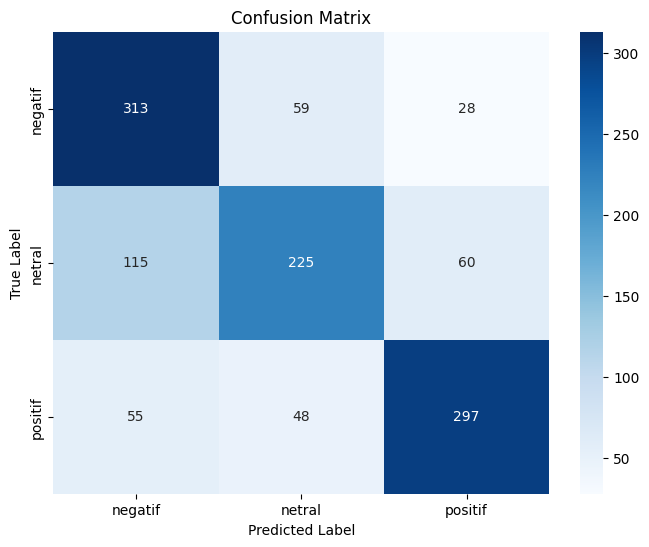

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Training
model = MultinomialNB(alpha=1.0, force_alpha=True, fit_prior=True)
model.fit(X_train_tfidf, y_train)

# Prediksi label
y_pred = model.predict(X_test_tfidf)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Hitung precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Hitung recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# Hitung ROC AUC Score
# Dapatkan probabilitas dari model
y_score = model.predict_proba(X_test_tfidf)

# Binarisasi label y_test untuk multiclass AUC
classes = model.classes_
y_test_binarized = label_binarize(y_test, classes=classes)

# ROC AUC Score
roc_auc = roc_auc_score(y_test_binarized, y_score, multi_class='ovr', average='macro')
print(f"ROC AUC Score (multiclass - OvR): {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


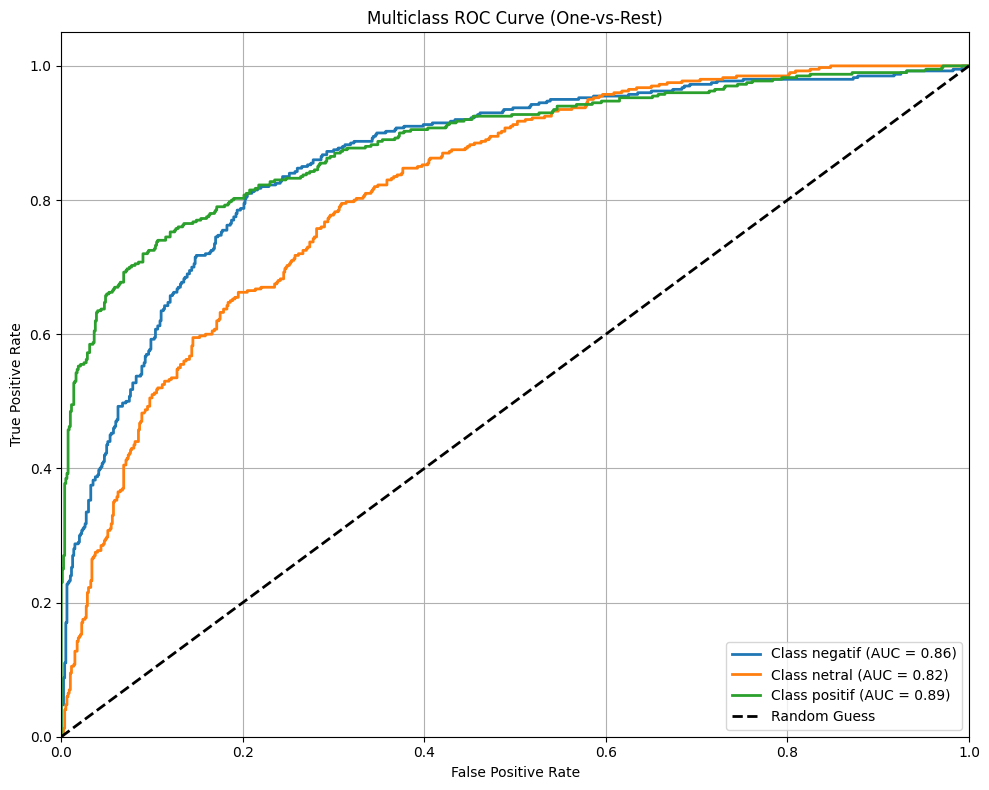

In [23]:
# Probabilitas prediksi
y_prob = model.predict_proba(X_test_tfidf)

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

classes = lb.classes_
n_classes = len(classes)

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.exceptions import NotFittedError

# Siapkan DataFrame hasil evaluasi
results = []

# Daftar model yang ingin diuji
models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "GaussianNB": GaussianNB(),
    "ComplementNB": ComplementNB()
}

# Loop semua model
for model_name, model in models.items():
    try:
        # GaussianNB butuh array, bukan sparse matrix
        if model_name == "GaussianNB":
            model.fit(X_train_tfidf.toarray(), y_train)
            y_pred = model.predict(X_test_tfidf.toarray())
            y_proba = model.predict_proba(X_test_tfidf.toarray())
        else:
            model.fit(X_train_tfidf, y_train)
            y_pred = model.predict(X_test_tfidf)
            y_proba = model.predict_proba(X_test_tfidf)

        # Hitung metrik
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        # ROC AUC multiclass (OvR)
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

        # Simpan ke results
        results.append({
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "ROC AUC": roc_auc
        })

    except Exception as e:
        # Tangani error model (misalnya tidak support proba, dsb)
        print(f"Model {model_name} error: {e}")
        continue

# Buat dataframe hasil evaluasi dan sorting
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

# Tampilkan hasil akhir
print("Hasil Evaluasi Model Naive Bayes (sorted by F1-Score):")
results_df_sorted


Hasil Evaluasi Model Naive Bayes (sorted by F1-Score):


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,ComplementNB,0.699167,0.702821,0.699167,0.695893,0.856980
1,MultinomialNB,0.695833,0.699058,0.695833,0.693463,0.855370
2,BernoulliNB,0.683333,0.702723,0.683333,0.686031,0.846318
3,GaussianNB,0.605000,0.617462,0.605000,0.605586,0.709961
